# Simulating TOD with <tt>ducc</tt>

In this notebook, we present a <a href="https://gitlab.mpcdf.mpg.de/mtr/ducc"><tt>ducc</tt></a>-based pipeline to simulate time-ordered data (TOD) for:
- an experiment with a LiteBIRD-like scanning strategy;
- offset detectors (not at boresight);
- a noise component;
- a dipole component.

Each of these functionalities is discussed in the corresponding (numbered) section.

## 1) LiteBIRD-like scanning strategy

We have written a slightly modified version of beamconv's <tt>scanning.py</tt> module (<tt>scanning_mod.py</tt>) that allows to simulate a LiteBIRD-like scanning strategy. The <tt>scanning.py</tt> module is based on the <a href="https://github.com/tmatsumu/LB_SYSPL_v4.2"><tt>pyScan</tt></a> code written by Tomotake Matsumura (IPMU).

Here we show how to use it.

#### Setting things up
First, we need to import a few modules and define some useful functions for plotting.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import healpy as hp
import time

import pysm3
import pysm3.units as u

import ducc0
import mueller_convolver
import scanning_mod

# setting up some plotting-related stuff
plt.rcParams.update({
    "font.size":10.95,
    "text.usetex":True,
    "font.family":"serif", 
    "font.serif":"cm"
    })

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('magma')
new_cmap = truncate_colormap(cmap, 0.2, 1)

#### Preparing input maps
We generate I, Q and U input maps from some <tt>pysm</tt> sky model.

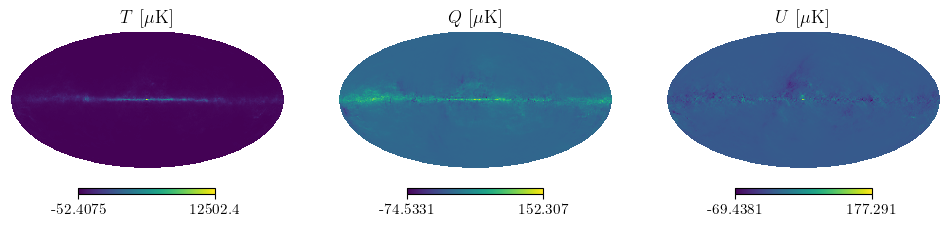

In [2]:
nside = 128
npix = 12*nside**2
lmax = 2*nside

sky = pysm3.Sky(nside=nside, preset_strings=["d10", "s5"], output_unit="uK_CMB")
nu = 140 

# generate input alm and maps
maps_pysm = sky.get_emission(nu * u.GHz)
slm = hp.map2alm(maps_pysm, lmax=lmax)
maps_temp = hp.alm2map(slm,nside=nside)

# plotting input maps
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))
plt.axes(ax1) 
hp.mollview(maps_temp[0], title=r'$T$ [$\mu$K]', hold=True)
plt.axes(ax2)
hp.mollview(maps_temp[1], title=r'$Q$ [$\mu$K]', hold=True)
plt.axes(ax3)
hp.mollview(maps_temp[2], title=r'$U$ [$\mu$K]', hold=True)
plt.show()

Since <tt>scanning_mod.py</tt> returns the pointings in ecliptic coordinates, we must transform the input maps in ecliptic coordinates and recompute their spherical harmonic coefficients.

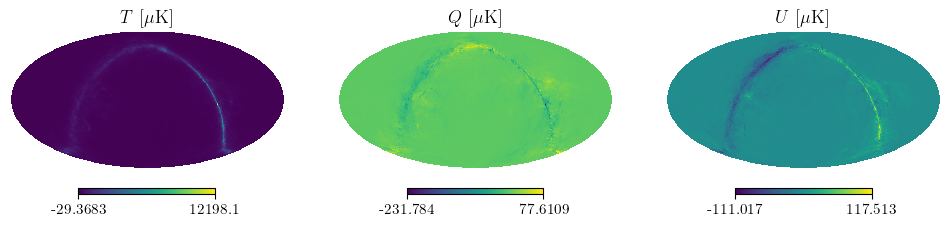

In [3]:
r = hp.Rotator(coord=['G','E'])
maps = r.rotate_map_alms(maps_temp)
slm = hp.map2alm(maps,lmax=lmax)

# plotting input maps
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))
plt.axes(ax1) 
hp.mollview(maps[0], title=r'$T$ [$\mu$K]', hold=True)
plt.axes(ax2)
hp.mollview(maps[1], title=r'$Q$ [$\mu$K]', hold=True)
plt.axes(ax3)
hp.mollview(maps[2], title=r'$U$ [$\mu$K]', hold=True)
plt.show()

#### Setting up ducc

First, we define a simple Gaussian beam to scan the sky. More complex beams can be fed to the code as $b_{\ell m}$ spherical harmonic coefficients.

In [4]:
def nalm(lmax, mmax):
    return ((mmax+1)*(mmax+2))//2 + (mmax+1)*(lmax-mmax)

def make_full_random_alm(lmax, mmax, rng):
    res = rng.uniform(-1., 1., (4, nalm(lmax, mmax))) \
     + 1j*rng.uniform(-1., 1., (4, nalm(lmax, mmax)))
    # make a_lm with m==0 real-valued
    res[:, 0:lmax+1].imag = 0.
    ofs=0
    # components 1 and 2 are spin-2, fix them accordingly
    spin=2
    for s in range(spin):
        res[1:3, ofs:ofs+spin-s] = 0.
        ofs += lmax+1-s
    return res

def get_gauss_beam_from_beamconv(fwhm, lmax):
    import beamconv
    blmT, blmm2 = beamconv.tools.gauss_blm(fwhm*180*60/np.pi, lmax, pol=True)
    res = np.zeros((4,blmT.shape[0]), dtype=np.complex128)
    blmE, blmB = beamconv.tools.spin2eb(blmm2, blmm2*0, spin=2)
    res[0] = blmT
    res[1] = blmE
    res[2] = blmB
    res[3] = blmT  # correct?
    return res

def blm_gauss_new(fwhm, lmax, pol=False):
    fwhm = float(fwhm)
    lmax = int(lmax)
    pol = bool(pol)
    mmax = 2 if pol else 0
    ncomp = 3 if pol else 1
    nval = hp.Alm.getsize(lmax, mmax)

    if mmax > lmax:
        raise ValueError("lmax value too small")

    blm = np.zeros((ncomp, nval), dtype=np.complex128)
    sigmasq = fwhm * fwhm / (8 * np.log(2.0))

    for l in range(lmax+1):
        blm[0, hp.Alm.getidx(lmax, l, 0)] = np.exp(-0.5*sigmasq*l*(l+1))

    if pol:
        for l in range(2, lmax+1):
            blm[1, hp.Alm.getidx(lmax, l, 2)] = np.exp(-0.5 * sigmasq * (l*(l+1)-4))
        blm[2] = 1j * blm[1]

    return blm

# blm_gauss_new times sqrt((2*l+1)/(4pi))
def Blm_gauss_new(fwhm, lmax, pol=False):
    blm = blm_gauss_new(fwhm, lmax, pol)
    for l in range(lmax+1):
        blm[0, hp.Alm.getidx(lmax, l, 0)] *= np.sqrt((2*l+1) / (4*np.pi))

    if pol:
        for l in range(2, lmax+1):
            blm[1:3, hp.Alm.getidx(lmax, l, 2)] *= np.sqrt((2*l+1) / (4*np.pi))

    return blm

In [5]:
np.random.seed(10)
rng = np.random.default_rng(np.random.SeedSequence(42))
kmax = 18

In [7]:
fwhm_arcmin = 5.
fwhm_rad = np.radians(fwhm_arcmin/60)

# completely random beam
blm = make_full_random_alm(lmax, lmax, rng)
blm = blm[:3]

# ... or use a Gauss beam
blmtmp = Blm_gauss_new(fwhm_rad, lmax, True)
blm *= 0
blm [0:3, 0:blmtmp.shape[1]] = blmtmp

#### Running ducc (LiteBIRD-like scanning strategy)

We use the functions defined in <tt>scanning_mod.py</tt> to compute LiteBIRD-like pointings.

In [8]:
ctim0 = 1510000000                    # initial time

duration = 3600*24*7                  # mission duration in s (7 days)
fsamp = 19.1                          # sampling frequency in Hz
nsamp = int(duration*fsamp)           # number of samples

In [33]:
fquat = fsamp
nquat = int(duration*fquat+1)

ctime_quat = ctim0 + np.arange(nquat)/fquat
theta, phi, psi = scanning_mod.ctime2bore(ctime_quat)

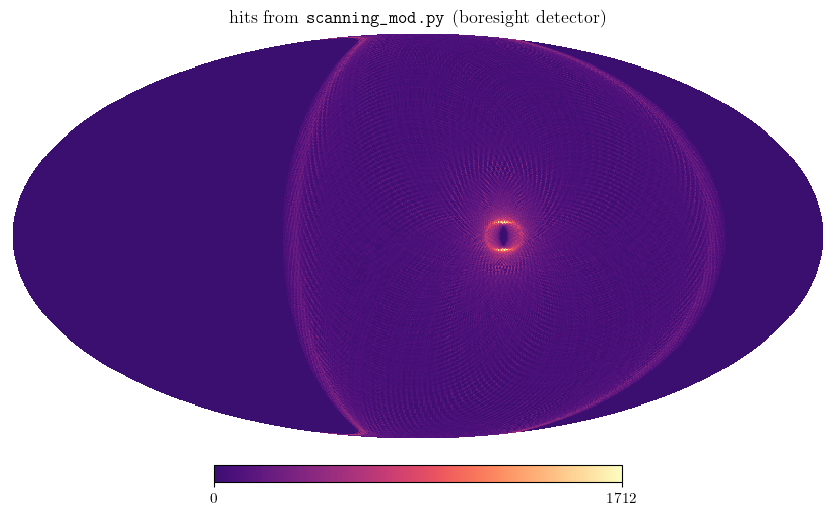

In [31]:
pixs = hp.ang2pix(nside, theta, phi)

hits = np.bincount(pixs)
        
hp.mollview(hits, cmap=new_cmap, title=r'hits from \texttt{scanning_mod.py} (boresight detector)')
plt.show()

Given the pontings, we can compute the TOD as follows.

In [32]:
# mock HWP specifics
hwp_angles = np.zeros(nsamp)
mueller = np.diag([1,1,1,1])

In [40]:
ptg = np.empty((nquat,3))
ptg[:,0] = theta
ptg[:,1] = phi
ptg[:,2] = psi

# make sure to be within the ranges for fullconv.signal
ptg[np.where(ptg[:,1]<0),1] += 2*np.pi
ptg[np.where(ptg[:,2]<0),2] += 2*np.pi

In [42]:
start = time.time()

fullconv = mueller_convolver.MuellerConvolver(
    lmax=lmax,
    kmax=kmax,
    slm=slm,
    blm=blm,
    mueller=mueller,
    single_precision=False,
    epsilon=1e-7,
    nthreads=1,
)
tod_noiseless = fullconv.signal(ptg=ptg, alpha=hwp_angles)
time_noiseless = time.time() - start

## 2) Reading detector offset quaternions

Here we show how to include detector offsets as quaternion with <tt>ducc</tt>.

First, we specify the time dependent boresight quaternion and the offset quaternions. Note that the offset quaternions can be sampled at a lower rate.

In [43]:
fquat = fsamp
nquat = int(duration*fquat+1)

ctime_quat = ctim0 + np.arange(nquat)/fquat
theta, phi, psi = scanning_mod.ctime2bore(ctime_quat)

q_bore = np.empty((nquat, 4))

for i in np.arange(nquat):
    q_bore[i] = ducc0.misc.ptg2quat(np.array([theta[i],phi[i],np.pi-psi[i]])) #CONVENTIONS!
    
quats = np.zeros((2,2,4))
quats[0,0,:] = np.array([1.,0.,0.,0.])
quats[0,1,:] = np.array([0.9958350838447524, 0.009165646421980997, 0.09071095143135842, 0.0])
quats[1,0,:] = np.array([0.9200679609994841, 0.03704627596838304, 0.08283588163313664, 0.3811046277509462])
quats[1,1,:] = np.array([0.9950353446904406, 0.05236230340491963, 0.08463363396964103, 0.0])

And use <tt>PointingProvider</tt> to compute the corresponding pointings.

In [21]:
hits = np.zeros(npix)

for i in np.arange(2):
    for j in np.arange(2):
        off_quat = np.roll(quats[i,j],-1) #CONVENTIONS!
        off_quat[0] *= -1                 #CONVENTIONS!
        
        print(off_quat)
        
        new_quats = np.empty((nsamp,4))

        pp = ducc0.pointingprovider.PointingProvider(t0=ctim0, freq=fquat, quat=q_bore, nthreads=1)
        rotated_quats = pp.get_rotated_quaternions(t0=ctim0, freq=fsamp, rot=off_quat, rot_left=True, out=new_quats)

        rotated_pointings = np.empty((nsamp, 3))

        for k in np.arange(nsamp):
            rotated_pointings[k] = ducc0.misc.quat2ptg(rotated_quats[k])

        pixs = hp.ang2pix(nside, rotated_pointings[:,0], rotated_pointings[:,1])

        hits += np.bincount(pixs,minlength=npix)

[-0.  0.  0.  1.]
[-0.00916565  0.09071095  0.          0.99583508]
[-0.03704628  0.08283588  0.38110463  0.92006796]
[-0.0523623   0.08463363  0.          0.99503534]


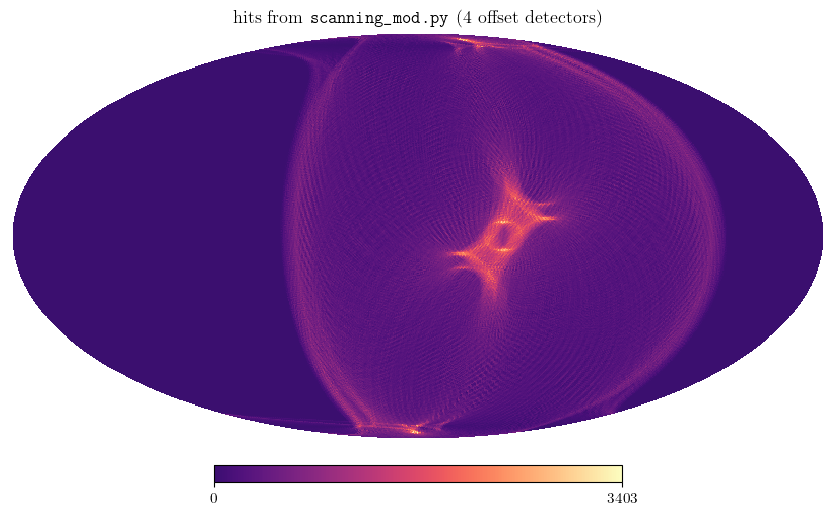

In [22]:
hp.mollview(hits, cmap=new_cmap, title=r'hits from \texttt{scanning_mod.py} (4 offset detectors)')
plt.show()

## 3) Adding a noise realization

We include a noise component by means of <tt>ducc</tt>'s <tt>OofaNoise</tt> function.

The noise can have a white and a $1/f$ component and is described by the (frequency) power spectrum $P(f)=\sigma^2\left[\frac{f^2+f_\text{knee}^2}{f^2+f_\text{min}^2}\right]^{\frac{\alpha}{2}}$.

In [49]:
start = time.time()

# parameters for generating noise with ducc0 P(f)=sigma^2[(f^2+f_knee^2)/(f^2+f_min^2)]^(slope/2)
# (for a 5 days observation, the minimum observable frequency is around 1e-6 Hz)
noise_tod = True 
sigma = 100 
f_min = 1e-5 
f_knee = 0.02 
slope = -2.0

gen = ducc0.misc.OofaNoise(sigma, f_min, f_knee, fsamp, slope)

inp = np.random.normal(0.,1.,(nsamp+1,))
tod_noisy = tod_noiseless + gen.filterGaussian(inp)

time_noisy = time.time() - start

Here we plot the first 2000 values of the noisy TOD we have just simulated, together with its noiseless counterpart.

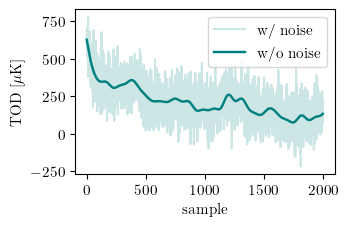

In [50]:
points=2000
color='teal'

plt.figure(figsize=(3.6, 2.4))
plt.plot(tod_noisy[:points],color=color,alpha=0.2,label='w/ noise')
plt.plot(tod_noiseless[:points],color=color,linewidth=1.75,label='w/o noise')
plt.legend()
plt.xlabel(r'sample')
plt.ylabel(r'TOD [$\mu$K]')
plt.tight_layout()
plt.savefig('noise_TOD.pdf')
plt.show()

As a countercheck, we take the difference of the noisy and noiseless TOD and check that its power spectrum tends to the theoretical one.

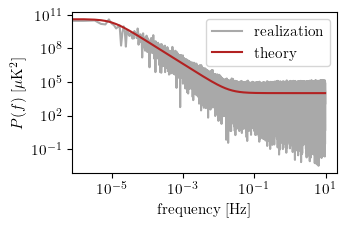

In [51]:
diff = tod_noisy - tod_noiseless

# Evaluating  and plotting the power spectrum
ps = np.abs(np.fft.fft(diff))**2 / nsamp
time_step = 1. / fsamp
freqs = np.fft.fftfreq(diff.size, time_step)
ps_theory = sigma**2 * ((freqs**2+f_knee**2)/(freqs**2+f_min**2))**(-slope/2)

plt.figure(figsize=(3.6, 2.4))
plt.loglog(freqs[:ps.size//2],ps[:ps.size//2],'darkgray',label='realization')
plt.loglog(freqs[:ps.size//2],ps_theory[:ps.size//2],'firebrick',label='theory')
plt.legend()
plt.xlabel(r'frequency [Hz]')
plt.ylabel(r'$P(f)$ [$\mu$K$^2$]')
plt.tight_layout()
plt.savefig('noise_spectrum.pdf')
plt.show()

## 3) Adding a dipole component to the TOD
To include a (Solar + orbital) dipole component, we borrow the <tt>dipole</tt> module of the <a href="https://github.com/litebird/litebird_sim"><tt>LiteBIRD-sim</tt></a> framework, which returns
the dipole TOD, given the time and direction of observation.

According to <a href="https://litebird-sim.readthedocs.io/en/latest/dipole.html"><tt>LiteBIRD-sim</tt>'s documentation</a>:

<blockquote cite="https://litebird-sim.readthedocs.io/en/latest/dipole.html">
The class SpacecraftOrbit is a dataclass that is able to initialize its members to sensible default values, which are taken from the literature. As the LiteBIRD orbit around L2 is not fixed yet, the code assumes a WMAP-like Lissajous orbit, <a href="https://arc.aiaa.org/doi/10.2514/6.2008-3315">[1]</a>. For the Sun velocity it assumes Planck 2018 solar dipole <a href="https://arxiv.org/abs/1807.06207">[6]</a>.
</blockquote>

In [69]:
start = time.time()

from astropy.time import Time
from astropy.constants import c as c_light
from astropy.constants import h, k_B

from beamconv import spacecraft

tod_dipole = tod_noiseless

nchunks = len(tod_dipole)//(24*3600*fsamp)
time_span_s = 24*3600

for i in np.arange(nchunks):
    # setting up the scanning strategy parameters
    ctime0_dipole = Time(ctim0+i*24*3600, format="unix") #conversion to astropy object
    orbit = spacecraft.SpacecraftOrbit(ctime0_dipole)

    pos_vel = spacecraft.spacecraft_pos_and_vel(orbit, start_time=ctime0_dipole, 
                                     time_span_s=time_span_s, delta_time_s=time_span_s)

    #pos_test = pos_vel.positions_km[:-1]
    vel_test = pos_vel.velocities_km_s[:-1][0]

    C_LIGHT_KM_S = c_light.value / 1e3
    H_OVER_K_B = h.value / k_B.value

    def planck(nu_hz, t_k):
        """Return occupation number at frequency nu_hz and temperature t_k"""
        return 1 / (np.exp(H_OVER_K_B * nu_hz / t_k) - 1)

    def compute_scalar_product(theta, phi, v):
        """Return the scalar (dot) product between a given direction and a velocity"""
        dx, dy, dz = np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)
        return dx * v[0] + dy * v[1] + dz * v[2]

    def calculate_beta(theta, phi, v_km_s):
        """Return a 2-tuple containing β·n and β"""
        beta_dot_n = compute_scalar_product(theta, phi, v_km_s) / C_LIGHT_KM_S
        beta = np.sqrt(v_km_s[0] ** 2 + v_km_s[1] ** 2 + v_km_s[2] ** 2) / C_LIGHT_KM_S
        return beta_dot_n, beta

    # Full formula in linearized units (the most widely used):
    def compute_dipole_for_one_sample_total_from_lin_t(theta, phi, v_km_s, t_cmb_k, nu_hz, f_x, planck_t0):
        beta_dot_n, beta = calculate_beta(theta, phi, v_km_s)
        gamma = 1 / np.sqrt(1 - beta ** 2)
        planck_t = planck(nu_hz, t_cmb_k / gamma / (1 - beta_dot_n))
        return t_cmb_k / f_x * (planck_t / planck_t0 - 1)

    def compute_dipole_for_one_chunk_total_from_lin_t(theta, phi, v_km_s, t_cmb_k, nu_hz, f_x, planck_t0):
        dipole = np.empty(len(theta))
        for i in range(len(theta)): #FIXME: avoid for loop!
            dipole[i] = compute_dipole_for_one_sample_total_from_lin_t(theta[i], phi[i], v_km_s, 
                                                                       t_cmb_k, nu_hz, f_x, planck_t0)
        return dipole

    t_cmb_k = 2.72548 # Fixsen 2009 http://arxiv.org/abs/0911.1955
    nu_hz = nu*1e9
    x = h.value * nu_hz / (k_B.value * t_cmb_k)
    f_x = x * np.exp(x) / (np.exp(x) - 1)
    planck_t0 = planck(nu_hz, t_cmb_k)
    
    idx_start = int(i*24*3600*fsamp)
    idx_end = int((i+1)*24*3600*fsamp)
    
    theta_chunk = ptg[idx_start:idx_end,0]
    phi_chunk = ptg[idx_start:idx_end,1]

    dipole_chunk = compute_dipole_for_one_chunk_total_from_lin_t(theta_chunk,phi_chunk,vel_test,t_cmb_k,nu_hz,f_x,planck_t0)*1e6

    tod_dipole[idx_start:idx_end] += dipole_chunk
    
time_dipole = time.time() - start

## Rough time requirements

As a reference, we print the time it took to simulate the TOD in the three cases we just considered: without noise and dipole, with noise (but no dipole) and with dipole (but no noise). All three TOD are simulated for a single detector with $f_\text{samp}=19.1\,\mathrm{Hz}$ taking data for 7 days. The noiseless component takes aorund 1.2 seconds to be simulated and the noise-only component 0.4 seconds. When including the dipole the running time increases substantially (around 90 seconds).

In [70]:
print(time_noiseless)
print(time_noisy)
print(time_dipole)

1.1834003925323486
0.35743045806884766
87.48857760429382
